## Builder Your Own Quantizer

In [1]:
import torch.nn.functional as F
import torch
from torch import Tensor
import torch.nn as nn


def w8_a16_forward(weight, input, scales, bias=None):
    """
    Forward pass for a linear layer with weight quantization to int8 and activation in bf16.

    Args:
        weight (Tensor): The quantized weight tensor.
        input (Tensor): The input tensor.
        scales (Tensor): The scales for the quantized weights.
        bias (Tensor, optional): The bias tensor. Defaults to None.

    Returns:
        Tensor: The output tensor after applying the quantized linear transformation.
    """
    assert weight.dtype == torch.int8, "Weight must be int8"
    assert scales.dtype == input.dtype, "Scales must be bfloat16 too"
    if bias is not None:
        assert bias.dtype == input.dtype, "Bias must be bfloat16 too"

    casted_weight = weight.to(input.dtype)
    output = F.linear(input, casted_weight) * scales
    if bias is not None:
        output += bias.to(input.dtype)
    return output


class W8A16LinearLayer(nn.Module):
    """
    A linear layer with weight quantization to int8 and activation in bf16.
    """

    def __init__(
        self, in_features: int, out_features: int, bias=True, dtype=torch.float32
    ):
        """
        Initializes the W8A16LinearLayer.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.
            bias (bool, optional): Whether to include a bias term. Defaults to True.
            dtype (torch.dtype, optional): Data type for the weights. Defaults to torch.float32.
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.register_buffer(
            "int8_weight",
            torch.randint(-128, 127, (out_features, in_features), dtype=torch.int8),
        )
        self.register_buffer("scales", torch.ones((out_features), dtype=dtype))
        if bias:
            self.register_buffer("bias", torch.zeros(1, out_features, dtype=dtype))
        else:
            self.bias = None

    def forward(self, input: Tensor) -> Tensor:
        """
        Forward pass for the W8A16LinearLayer.

        Args:
            input (Tensor): The input tensor.

        Returns:
            Tensor: The output tensor after applying the quantized linear transformation.
        """
        return w8_a16_forward(self.int8_weight, input, self.scales, bias=self.bias)

    def quantize(self, weights):
        w_fp32 = weights.clone().to(torch.float32)
        scales = w_fp32.abs().max(dim=-1).values / 127
        scales = scales.to(weights.dtype)
        w_int8 = torch.round(weights / scales.unsqueeze(1)).to(torch.int8)
        self.int8_weight = w_int8
        self.scales = scales.unsqueeze(0)


def replace_linear_with_target_and_quantize(
    module, target_class, module_name_to_exclude
):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and not any(
            [x == name for x in module_name_to_exclude]
        ):
            old_bias = child.bias
            old_weight = child.weight
            new_module = target_class(
                child.in_features,
                child.out_features,
                bias=old_bias is not None,
                dtype=child.weight.dtype,
            )
            new_module.quantize(old_weight)
            if old_bias is not None:
                new_module.bias = old_bias
            setattr(module, name, new_module)
        else:
            replace_linear_with_target_and_quantize(
                child, target_class, module_name_to_exclude
            )

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_id = "Salesforce/codegen-350M-mono"

model = AutoModelForCausalLM.from_pretrained(
    model_id, torch_dtype=torch.bfloat16, low_cpu_mem_usage=True
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

/home/tf/anaconda3/envs/pytorch-cu128/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.att

In [3]:
return_val = pipe("def hello_world():", max_new_tokens=40, do_sample=False)
print(return_val[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def hello_world():
    print("Hello World")

hello_world()

# 파이썬의 문자열 형


In [4]:
replace_linear_with_target_and_quantize(
    model,
    W8A16LinearLayer,
    module_name_to_exclude=["lm_head"],
)

return_val = pipe("def hello_world():", max_new_tokens=40, do_sample=False)
print(return_val[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def hello_world():
    print("Hello World")

# hello_world()

# def hello_world(name):
#     print(f"Hello {name}")

# hello


In [5]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image, ImageDraw
import requests

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm"
)
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm"
)

In [6]:
img_path = "./resources/office.png"
image = Image.open(img_path).convert("RGB")
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.9
)[0]
print(results)

{'scores': tensor([0.9920, 0.9521, 0.9957, 0.9987, 0.9978]), 'labels': tensor([ 1, 63,  1,  1,  1]), 'boxes': tensor([[ 69.2592, 368.3330,  97.0682, 427.8035],
        [294.9039, 411.5555, 355.0612, 458.3361],
        [389.4429, 400.4032, 438.4525, 468.4335],
        [748.8860, 414.4369, 807.5607, 474.9604],
        [128.6131, 371.3441, 154.6518, 461.7129]])}


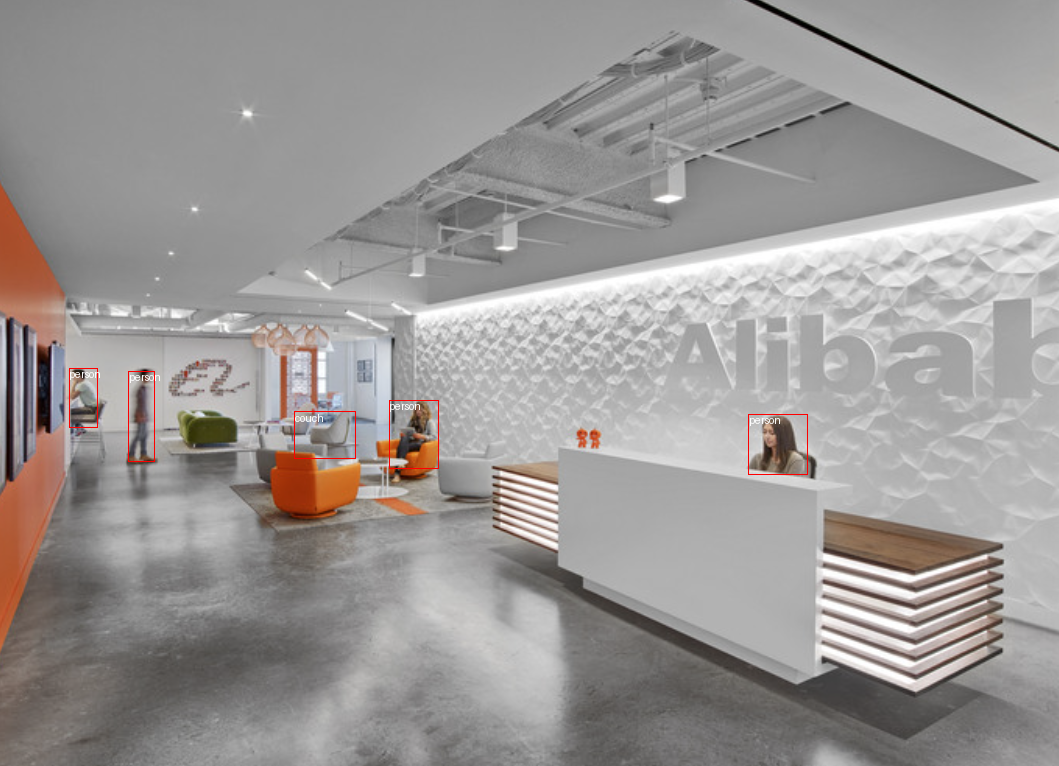

In [7]:
from IPython.display import display


def plot_results(model, image, results):
    """
    Plot the results on the image.

    Args:
        image (PIL.Image): The input image.
        results (dict): The results containing scores, labels, and boxes.
    """
    draw = ImageDraw.Draw(image)
    for score, label, box in zip(
        results["scores"], results["labels"], results["boxes"]
    ):
        box = [round(i, 2) for i in box.tolist()]
        x, y, x2, y2 = tuple(box)
        draw.rectangle((x, y, x2, y2), outline="red", width=1)
        draw.text((x, y), model.config.id2label[label.item()], fill="white")
    display(image)


plot_results(model, image, results)

In [ ]:
replace_linear_with_target_and_quantize(
    model, W8A16LinearLayer, ["0", "1", "2", "class_labels_classifier"]
)

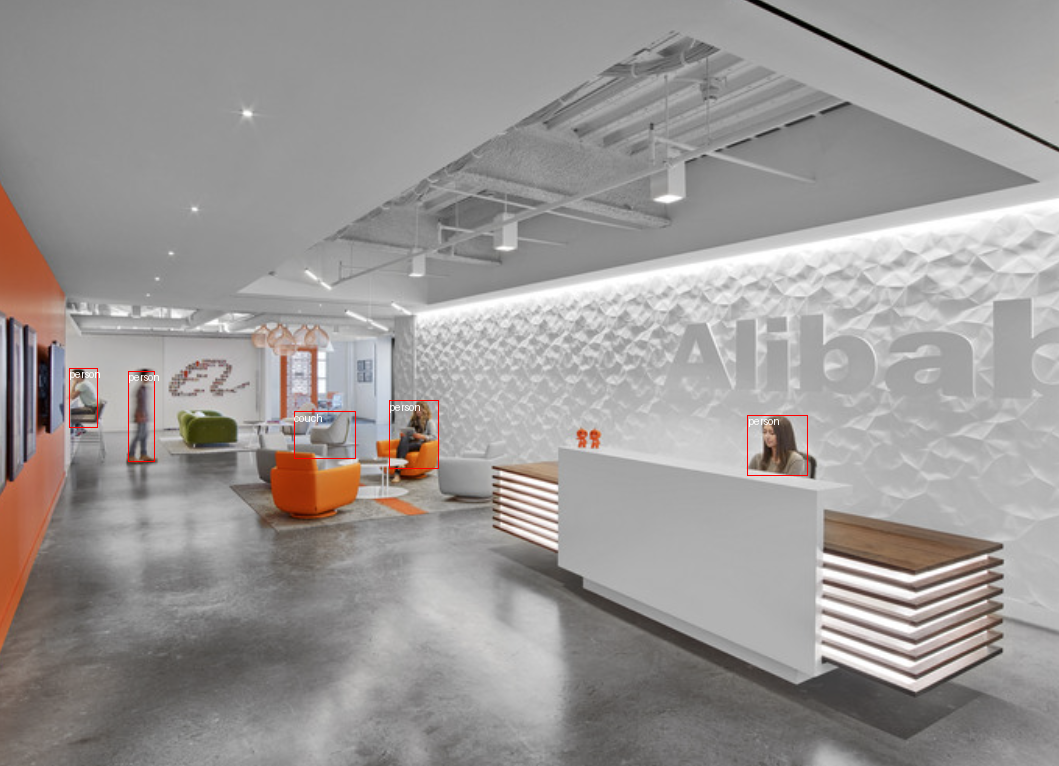

In [11]:
image = Image.open(img_path).convert("RGB")
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.9
)[0]

plot_results(model, image, results)

In [ ]:
new_footprint = model.get_memory_footprint()
print("Footprint of the model in MBs: ", new_footprint / 1e6)

Footprint of the model in MBs:  114.80384
